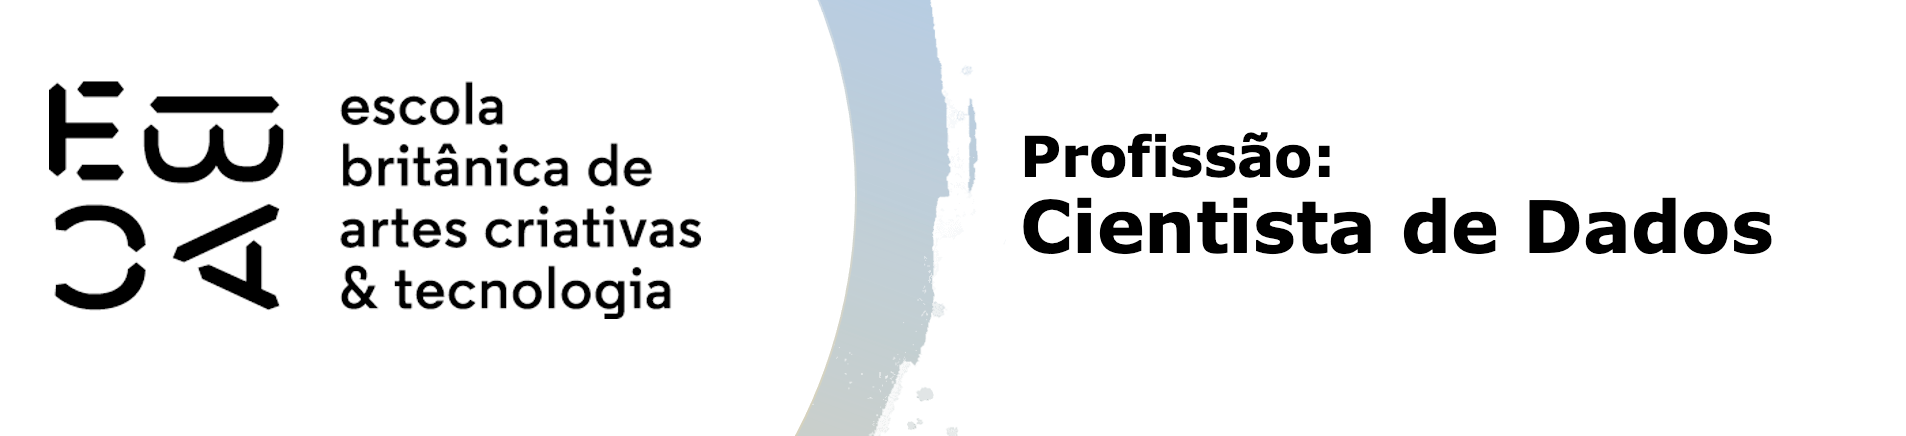

# Regressão III - Tarefa

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api  as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [264]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [265]:
df.shape

(750000, 13)

In [266]:
df.drop_duplicates();

In [267]:
df.isnull().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [268]:
df.fillna(df['tempo_emprego'].mean(), inplace=True)

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [269]:
df.index = pd.to_datetime(df.index)

print(f'''Meses presentes na base:
{[mes for mes in df.index.unique().strftime('%b%y')]}

Três últimos meses na base:
{[mes for mes in df[df.index > (df.index.unique().max() - pd.DateOffset(months=3))].index.unique().strftime('%b%y')]}
''')

Meses presentes na base:
['Jan15', 'Feb15', 'Mar15', 'Apr15', 'May15', 'Jun15', 'Jul15', 'Aug15', 'Sep15', 'Oct15', 'Nov15', 'Dec15', 'Jan16', 'Feb16', 'Mar16']

Três últimos meses na base:
['Jan16', 'Feb16', 'Mar16']



In [270]:
meses_finais = df[df.index > (df.index.unique().max() - pd.DateOffset(months=3))].copy()

meses_finais.sample(5)

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2016-02-01,3756,F,S,S,0,Assalariado,Superior completo,Casado,Casa,49,8.605479,2.0,1441.54
2016-02-01,6689,F,N,S,0,Assalariado,Superior completo,Casado,Casa,47,6.646575,2.0,2021.92
2016-03-01,6177,F,N,S,0,Servidor público,Médio,Viúvo,Casa,48,23.178082,1.0,14226.24
2016-01-01,2711,M,S,N,1,Assalariado,Superior completo,Casado,Aluguel,29,0.556164,3.0,1622.12
2016-02-01,5720,M,S,N,0,Empresário,Superior incompleto,Casado,Casa,30,5.624658,2.0,3935.54


In [291]:
#base de treino sem o meses finais
df_train = df[~df.index.isin(meses_finais.index)].copy()

print(f'''Base de treino (df_train):
{[mes for mes in df_train.index.unique().strftime('%b%y')]}
''')

df_train.head(5)

Base de treino (df_train):
['Jan15', 'Feb15', 'Mar15', 'Apr15', 'May15', 'Jun15', 'Jul15', 'Aug15', 'Sep15', 'Oct15', 'Nov15', 'Dec15']



,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,quantil_tempo_emprego
data_ref,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,16
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,13
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,12
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,1
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,1


### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [272]:
#modelo de regressão com StatsModel
modelo1 = smf.ols(formula='np.log(renda) ~ tempo_emprego', 
                  data=df_train).fit()

print(f'R-quadrado ajustado: {modelo1.rsquared_adj:.2%}')

modelo1.summary()

R-quadrado ajustado: 41.74%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                 4.298e+05
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:42:12   Log-Likelihood:            -8.0817e+05
No. Observations:              600000   AIC:                         1.616e+06
Df Residuals:                  599998   BIC:                         1.616e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.2780      0.002   4262.716      0.000       8.274       8.282
tempo_emprego     0.1292      0.000    655.629      0.000       0.129       0.130
==============================================================================
Omnibus:                      798.953   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              717.227
Skew:                          -0.046   Prob(JB):                    1.80e-156
Kurtosis:                       2.857   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [273]:
df['quantil_tempo_emprego'] = pd.qcut(df['tempo_emprego'], 20, labels=False, duplicates='drop')

# Calcular a tabela de perfil
profile_table = df.groupby('quantil_tempo_emprego').agg(
    quantidade_observacoes=('tempo_emprego', 'size'),
    media_log_renda=('renda', lambda x: (x + 1).apply(np.log).mean()),  # Adicionando 1 para evitar log(0)
    media_tempo_emprego=('tempo_emprego', 'mean')
).reset_index()


tabela_perfil = pd.DataFrame(profile_table)
tabela_perfil

,quantil_tempo_emprego,quantidade_observacoes,media_log_renda,media_tempo_emprego
0,0,37699,8.135174,0.515096
1,1,37522,8.216375,1.124770
2,2,37437,8.335411,1.783247
3,3,37391,8.390599,2.513020
4,4,37915,8.522718,3.300942
5,5,37253,8.612601,3.989239
6,6,37401,8.673997,4.613535
7,7,37545,8.809883,5.367816
8,8,37495,8.905687,6.205161
9,9,37379,8.986655,7.010453


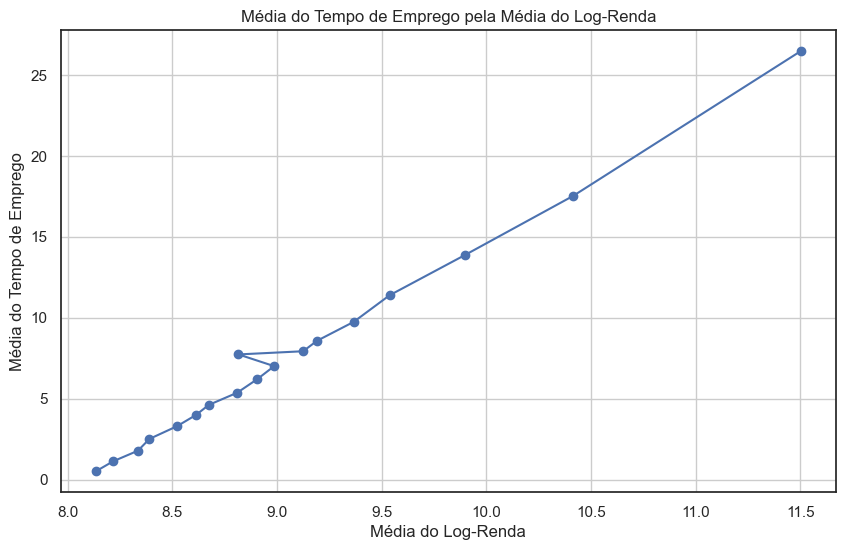

In [274]:
plt.figure(figsize=(10, 6))
plt.plot(profile_table['media_log_renda'], profile_table['media_tempo_emprego'], marker='o')
plt.xlabel('Média do Log-Renda')
plt.ylabel('Média do Tempo de Emprego')
plt.title('Média do Tempo de Emprego pela Média do Log-Renda')
plt.grid(True)
plt.show()

<blockquote>Ao analisar o gráfico da média do tempo de emprego pela média do log-renda, percebe-se uma tendência linear, sugerindo uma regressão linear simples. No entanto, a transformação logarítmica na variável dependente revela um crescimento exponencial. Portanto, tanto a categorização, a transformação logarítmica quanto a regressão segmentada podem ser eficazes. No entanto, o método Lowess pode ser a melhor escolha, pois ajusta-se ao formato exponencial e suaviza a curva conforme necessário.</blockquote>


### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [292]:
df_train.reset_index(drop=True, inplace=True)

In [293]:
df_train['renda_log'] = np.log(df_train['renda'])

In [294]:
df_train['cat_renda'], retbins = pd.qcut(x=df_train.renda, q=20, retbins=True, precision=0)

print(f'''Quantidade de categorias para 'cat_renda': {df_train.cat_renda.nunique()}''')

df_train

Quantidade de categorias para 'cat_renda': 20


,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,quantil_tempo_emprego,renda_log,cat_renda
0,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,16,9.318131,"(9966.0, 11497.0]"
1,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,13,7.793508,"(1689.0, 2449.0]"
2,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,12,9.528769,"(13339.0, 15536.0]"
3,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,1,7.767196,"(1689.0, 2449.0]"
4,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,1,6.673020,"(140.0, 1689.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,4650,F,N,S,1,Assalariado,Superior incompleto,Solteiro,Casa,37,4.441096,2.0,1893.35,6,7.546103,"(1689.0, 2449.0]"
599996,9717,M,S,S,0,Empresário,Médio,Casado,Estúdio,44,2.345205,2.0,3080.48,3,8.032841,"(2449.0, 3163.0]"
599997,7485,M,S,S,0,Assalariado,Médio,Casado,Casa,28,0.736986,2.0,5131.20,0,8.543095,"(4671.0, 5519.0]"
599998,15500,F,S,S,1,Empresário,Superior completo,Solteiro,Casa,27,6.791781,2.0,20449.25,9,9.925701,"(18368.0, 22081.0]"


In [295]:
# Criando um novo DataFrame df_cat2 com estatísticas resumidas para cada categoria da variável 'cat_renda'
df_cat2 = (df_train
           .groupby(by='cat_renda')
           .agg({'cat_renda':[('Quantidade de observações', 'count')], 
                 'tempo_emprego': [('Média do tempo de emprego', 'mean')], 
                 'renda_log': [('Média do renda_log', 'mean')]})
           .droplevel(level=0, axis=1))

# Exibindo o DataFrame df_cat2
df_cat2

,Quantidade de observações,Média do tempo de emprego,Média do renda_log
cat_renda,,,
"(140.0, 1689.0]",30000,3.495999,7.010163
"(1689.0, 2449.0]",30003,4.207643,7.632577
"(2449.0, 3163.0]",29998,4.660527,7.936228
"(3163.0, 3891.0]",30004,4.918947,8.165258
"(3891.0, 4671.0]",30002,5.252237,8.359802
"(4671.0, 5519.0]",29998,5.379107,8.533222
"(5519.0, 6458.0]",29998,5.643284,8.695236
"(6458.0, 7488.0]",29999,5.842475,8.846803
"(7488.0, 8648.0]",29998,6.083964,8.992746


In [296]:
# Preenchendo os valores ausentes da coluna 'tempo_emprego' no DataFrame de treino com a média do tempo de emprego correspondente à categoria da variável 'cat_renda'
df_train['tempo_emprego_fillna_2'] = (df_train['tempo_emprego']
                                      .fillna(value=df_train.merge(right=df_cat2, 
                                                                   how='left', 
                                                                   left_on='cat_renda', 
                                                                   right_index=True)['Média do tempo de emprego']))

# Exibindo o DataFrame de treino atualizado
df_train

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,quantil_tempo_emprego,renda_log,cat_renda,tempo_emprego_fillna_2
0,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,16,9.318131,"(9966.0, 11497.0]",16.717808
1,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,13,7.793508,"(1689.0, 2449.0]",9.600000
2,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,12,9.528769,"(13339.0, 15536.0]",8.208219
3,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,1,7.767196,"(1689.0, 2449.0]",1.301370
4,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,1,6.673020,"(140.0, 1689.0]",1.254795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,4650,F,N,S,1,Assalariado,Superior incompleto,Solteiro,Casa,37,4.441096,2.0,1893.35,6,7.546103,"(1689.0, 2449.0]",4.441096
599996,9717,M,S,S,0,Empresário,Médio,Casado,Estúdio,44,2.345205,2.0,3080.48,3,8.032841,"(2449.0, 3163.0]",2.345205
599997,7485,M,S,S,0,Assalariado,Médio,Casado,Casa,28,0.736986,2.0,5131.20,0,8.543095,"(4671.0, 5519.0]",0.736986
599998,15500,F,S,S,1,Empresário,Superior completo,Solteiro,Casa,27,6.791781,2.0,20449.25,9,9.925701,"(18368.0, 22081.0]",6.791781


In [297]:
df_train['renda_log'].fillna(df_train['renda_log'].mean());

In [298]:
df_train['renda_log'].isna().sum()

0

In [299]:
# Ajustando um novo modelo de regressão linear utilizando a variável 'tempo_emprego_fillna_2' como preditor da variável 'renda_log' no DataFrame de treino
modelo2 = smf.ols(formula='renda_log ~ tempo_emprego_fillna_2', data=df_train).fit()

# Imprimindo o R-quadrado ajustado dos dois modelos
print(f'R-quadrado ajustado (modelo1): {modelo1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo2): {modelo2.rsquared_adj:.2%}') 

# Exibindo um resumo do segundo modelo
modelo2.summary()

R-quadrado ajustado (modelo1): 41.74%
R-quadrado ajustado (modelo2): 41.74%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                 4.298e+05
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:56:35   Log-Likelihood:            -8.0817e+05
No. Observations:              600000   AIC:                         1.616e+06
Df Residuals:                  599998   BIC:                         1.616e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8.2780      0.002   4262.716      0.000       8.274       8.282
tempo_emprego_fillna_2     0.1292      0.000    655.629      0.000       0.129       0.130
==============================================================================
Omnibus:                      798.953   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              717.227
Skew:                          -0.046   Prob(JB):                    1.80e-156
Kurtosis:                       2.857   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [300]:
# Ajustando um terceiro modelo de regressão linear utilizando os dados resumidos do DataFrame df_cat2
modelo3 = smf.ols(formula='Q("Média do renda_log") ~ Q("Média do tempo de emprego")', data=df_cat2).fit()

# Imprimindo o R-quadrado ajustado dos três modelos
print(f'R-quadrado ajustado (modelo1): {modelo1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo2): {modelo2.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo3): {modelo3.rsquared_adj:.2%}') 

# Exibindo um resumo do terceiro modelo
modelo3.summary()

R-quadrado ajustado (modelo1): 41.74%
R-quadrado ajustado (modelo2): 41.74%
R-quadrado ajustado (modelo3): 81.15%


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Q("Média do renda_log")   R-squared:                       0.821
Model:                                 OLS   Adj. R-squared:                  0.811
Method:                      Least Squares   F-statistic:                     82.77
Date:                     Thu, 13 Jun 2024   Prob (F-statistic):           3.75e-08
Time:                             20:56:36   Log-Likelihood:                -14.878
No. Observations:                       20   AIC:                             33.76
Df Residuals:                           18   BIC:                             35.75
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          7.2806      0.250     29.094      0.000       6.755       7.806
Q("Média do tempo de emprego")     0.2579      0.028      9.098      0.000       0.198       0.318
==============================================================================
Omnibus:                        3.179   Durbin-Watson:                   0.314
Prob(Omnibus):                  0.204   Jarque-Bera (JB):                2.489
Skew:                          -0.843   Prob(JB):                        0.288
Kurtosis:                       2.620   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [301]:
# Combinando os resultados do modelo de regressão linear (modelo3) com as estatísticas resumidas do DataFrame df_cat2
df_modelo3 = (df_cat2
              .merge(right=modelo3.get_prediction().summary_frame(), 
                     on='cat_renda')
              .rename(columns={'Quantidade de observações':'qtd', 
                               'Média do tempo de emprego':'tempo_emprego', 
                               'Média do renda_log':'renda_log'}))

# Exibindo o DataFrame df_modelo3
df_modelo3

,qtd,tempo_emprego,renda_log,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
cat_renda,,,,,,,,,
"(140.0, 1689.0]",30000,3.495999,7.010163,8.182322,0.170048,7.825064,8.539579,6.999542,9.365102
"(1689.0, 2449.0]",30003,4.207643,7.632577,8.365881,0.156403,8.037291,8.694472,7.191442,9.540321
"(2449.0, 3163.0]",29998,4.660527,7.936228,8.482697,0.148496,8.170719,8.794675,7.312797,9.652597
"(3163.0, 3891.0]",30004,4.918947,8.165258,8.549354,0.144302,8.246186,8.852521,7.381772,9.716935
"(3891.0, 4671.0]",30002,5.252237,8.359802,8.635322,0.139277,8.342712,8.927931,7.470437,9.800206
"(4671.0, 5519.0]",29998,5.379107,8.533222,8.668046,0.137486,8.379199,8.956894,7.504101,9.831991
"(5519.0, 6458.0]",29998,5.643284,8.695236,8.736187,0.133991,8.454683,9.017692,7.574043,9.898332
"(6458.0, 7488.0]",29999,5.842475,8.846803,8.787566,0.131576,8.511135,9.063997,7.626640,9.948493
"(7488.0, 8648.0]",29998,6.083964,8.992746,8.849855,0.128920,8.579004,9.120707,7.690245,10.009466


In [302]:
# Criando uma função para plotar os resultados de um modelo de regressão
def plotar_resultados_regressao(data: pd.DataFrame) -> None:
    """
    Plota os dados observados, a média prevista e os intervalos de confiança de um modelo de regressão.

    Parâmetros:
        data (pd.DataFrame): DataFrame contendo os resultados da regressão.

    Retorna:
        None
    """
    # Criação do gráfico para exibir os resultados do modelo de regressão linear
    plt.figure(figsize=(18, 6))

    # Configurando o estilo do gráfico
    sns.set_theme(style='white')

    # Plotando os dados observados
    plt.plot(data['tempo_emprego'], data['renda_log'], 'bo', alpha=.9, label='Dados observados')
    
    # Plotando uma linha conectando os dados observados
    plt.plot(data['tempo_emprego'], data['renda_log'], '-', alpha=.3)

    # Plotando a média prevista
    plt.plot(data['tempo_emprego'], data['mean'], 'g-.', label='Média prevista')

    # Plotando o intervalo de confiança da média
    plt.plot(data['tempo_emprego'], data['mean_ci_lower'], ':', color='orange', label='Intervalo de confiança da média')
    plt.plot(data['tempo_emprego'], data['mean_ci_upper'], ':', color='orange')

    # Plotando o intervalo de confiança para a variável de resposta
    plt.plot(data['tempo_emprego'], data['obs_ci_lower'], 'r--', label='Intervalo de confiança para a variável de resposta')
    plt.plot(data['tempo_emprego'], data['obs_ci_upper'], 'r--')

    # Adicionando legenda
    plt.legend(loc='best')

    # Exibindo o gráfico
    plt.show()

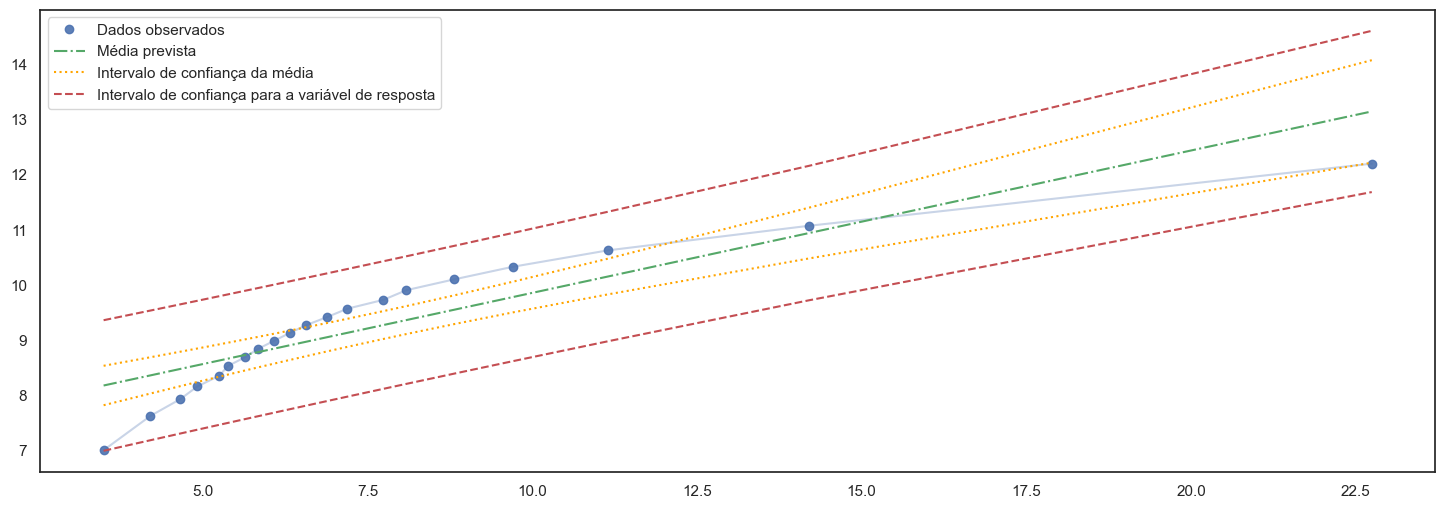

In [303]:
plotar_resultados_regressao(data=df_modelo3)

In [304]:
# Criando um novo DataFrame df_train2 a partir do DataFrame df_cat2
# Selecionando apenas as colunas relevantes (tempo_emprego e renda_log), redefinindo os índices e renomeando as colunas
df_train2 = (df_cat2
             .iloc[:,1:]  # Excluindo a primeira coluna
             .reset_index(drop=True)  # Redefinindo os índices
             .rename(columns={'Média do tempo de emprego':'tempo_emprego', 'Média do renda_log':'renda_log'}))  # Renomeando as colunas

# Exibindo o DataFrame df_train2
df_train2

,tempo_emprego,renda_log
0,3.495999,7.010163
1,4.207643,7.632577
2,4.660527,7.936228
3,4.918947,8.165258
4,5.252237,8.359802
5,5.379107,8.533222
6,5.643284,8.695236
7,5.842475,8.846803
8,6.083964,8.992746
9,6.324065,9.135799


In [305]:
# Dividindo a variável 'tempo_emprego' em 10 categorias usando quantis e retornando os pontos de corte dos intervalos de cada categoria
df_train2['tempo_emprego_cat'], q = pd.qcut(x=df_train2.tempo_emprego, q=10, retbins=True, duplicates='drop')

# Exibindo os pontos de corte dos intervalos de cada categoria
q

array([ 3.49599901,  4.61523865,  5.18557902,  5.56403098,  5.98736848,
        6.44923734,  7.01220251,  7.84632801,  8.99164702, 11.45280185,
       22.74252495])

In [306]:
# Definindo os pontos de corte para dividir a variável 'tempo_emprego' em intervalos
q = [-np.inf, #2.82831955, 
     3.88489973, 
     4.52253642, 
#      5.01507938, 
     5.54815254, 
#      6.1206601, 
     6.82530007, 
#      7.86743048, 
     9.2254007, 
#      11.88062575, 
     np.inf #22.86804915
    ]

# Criando uma nova coluna 'tempo_emprego_cat' no DataFrame df_train2, contendo os intervalos definidos pelos pontos de corte
df_train2['tempo_emprego_cat'] = pd.cut(x=df_train2.tempo_emprego, bins=q)

# Criando um novo DataFrame df_train3
df_train3 = pd.DataFrame()

# Calculando a média da variável 'renda_log' para cada intervalo da variável 'tempo_emprego_cat'
df_train3['y_mean'] = df_train2.groupby(by='tempo_emprego_cat')['renda_log'].mean()

# Calculando o erro padrão da média da variável 'renda_log' para cada intervalo da variável 'tempo_emprego_cat'
std_error = df_train2.groupby(by='tempo_emprego_cat')['renda_log'].sem()

# Calculando os limites superior e inferior do intervalo de confiança de 95% para a média da variável 'renda_log'
df_train3['y_max'] = df_train3['y_mean'] + std_error * 2
df_train3['y_min'] = df_train3['y_mean'] - std_error * 2

# Combinando os resultados com o DataFrame df_train2
df_train3 = df_train2.merge(right=df_train3, how='left', left_on='tempo_emprego_cat', right_index=True)

# Exibindo o DataFrame df_train3
df_train3

,tempo_emprego,renda_log,tempo_emprego_cat,y_mean,y_max,y_min
0,3.495999,7.010163,"(-inf, 3.885]",7.010163,NaN,NaN
1,4.207643,7.632577,"(3.885, 4.523]",7.632577,NaN,NaN
2,4.660527,7.936228,"(4.523, 5.548]",8.248627,8.505465,7.991789
3,4.918947,8.165258,"(4.523, 5.548]",8.248627,8.505465,7.991789
4,5.252237,8.359802,"(4.523, 5.548]",8.248627,8.505465,7.991789
5,5.379107,8.533222,"(4.523, 5.548]",8.248627,8.505465,7.991789
6,5.643284,8.695236,"(5.548, 6.825]",8.989615,9.195192,8.784039
7,5.842475,8.846803,"(5.548, 6.825]",8.989615,9.195192,8.784039
8,6.083964,8.992746,"(5.548, 6.825]",8.989615,9.195192,8.784039
9,6.324065,9.135799,"(5.548, 6.825]",8.989615,9.195192,8.784039


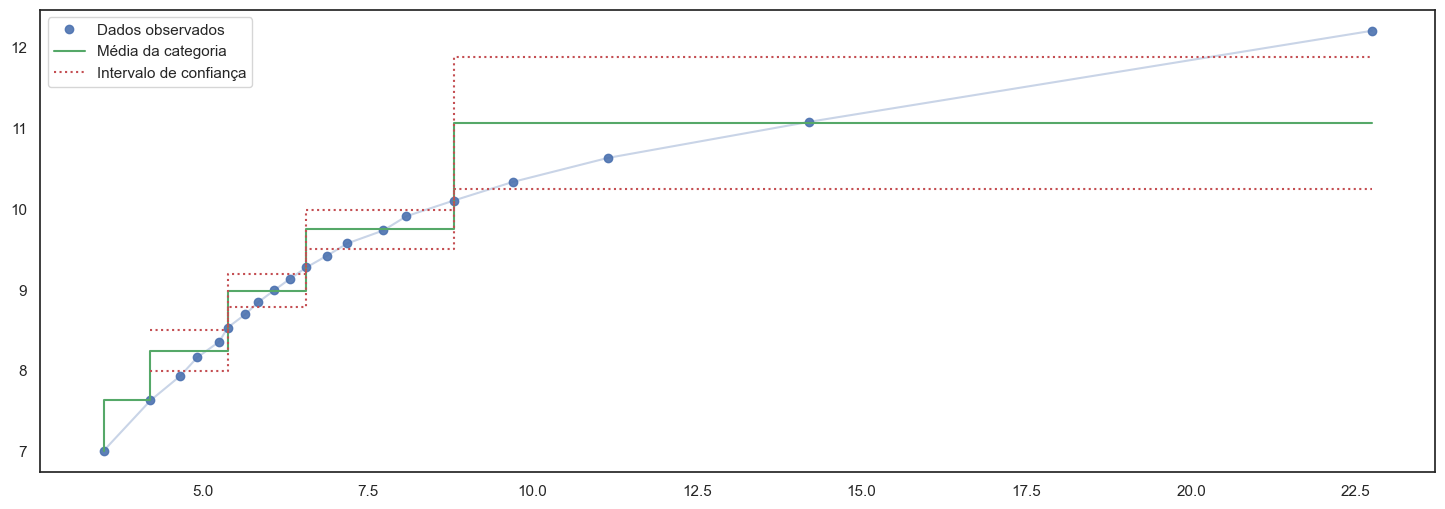

In [307]:
# Criando um gráfico para visualizar os dados observados, a média da categoria e o intervalo de confiança da variável 'renda_log' em relação à variável 'tempo_emprego'
plt.figure(figsize=(18,6))

# Plotando os dados observados
plt.plot(df_train3.tempo_emprego, df_train3.renda_log, 'bo', alpha=.9, label='Dados observados')

# Plotando uma linha conectando os dados observados
plt.plot(df_train3.tempo_emprego, df_train3.renda_log, '-', alpha=.3)

# Plotando a média da categoria
plt.step(df_train3.tempo_emprego, df_train3.y_mean, 'g-', label='Média da categoria')

# Plotando o intervalo de confiança
plt.step(df_train3.tempo_emprego, df_train3.y_max, 'r:', label='Intervalo de confiança')
plt.step(df_train3.tempo_emprego, df_train3.y_min, 'r:')

# Adicionando legenda
plt.legend(loc='best')

# Exibindo o gráfico
plt.show()

In [308]:
# Ajustando um novo modelo de regressão linear usando a variável categórica 'tempo_emprego_cat' como preditora da variável 'renda_log' no DataFrame df_train3
modelo4 = smf.ols(formula='renda_log ~ tempo_emprego_cat', data=df_train3).fit()

# Imprimindo o R-quadrado ajustado dos quatro modelos anteriores
print(f'R-quadrado ajustado (modelo1): {modelo1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo2): {modelo2.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo3): {modelo3.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo4): {modelo4.rsquared_adj:.2%}') 

# Exibindo um resumo completo do quarto modelo
modelo4.summary()

R-quadrado ajustado (modelo1): 41.74%
R-quadrado ajustado (modelo2): 41.74%
R-quadrado ajustado (modelo3): 81.15%
R-quadrado ajustado (modelo4): 87.31%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     27.15
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           9.77e-07
Time:                        20:56:50   Log-Likelihood:                -8.4026
No. Observations:                  20   AIC:                             28.81
Df Residuals:                      14   BIC:                             34.78
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       7.0102      0.440     15.924      0.000       6.066       7.954
tempo_emprego_cat[T.Interval(3.885, 4.523, closed='right')]     0.6224      0.623      1.000      0.334      -0.713       1.958
tempo_emprego_cat[T.Interval(4.523, 5.548, closed='right')]     1.2385      0.492      2.516      0.025       0.183       2.294
tempo_emprego_cat[T.Interval(5.548, 6.825, closed='right')]     1.9795      0.482      4.105      0.001       0.945       3.014
tempo_emprego_cat[T.Interval(6.825, 9.225, closed='right')]     2.7385      0.482      5.679      0.000       1.704       3.773
tempo_emprego_cat[T.Interval(9.225, inf, closed='right')]       4.0497      0.492      8.228      0.000       2.994       5.105
==============================================================================
Omnibus:                       10.559   Durbin-Watson:                   1.421
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                9.237
Skew:                           1.025   Prob(JB):                      0.00987
Kurtosis:                       5.623   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

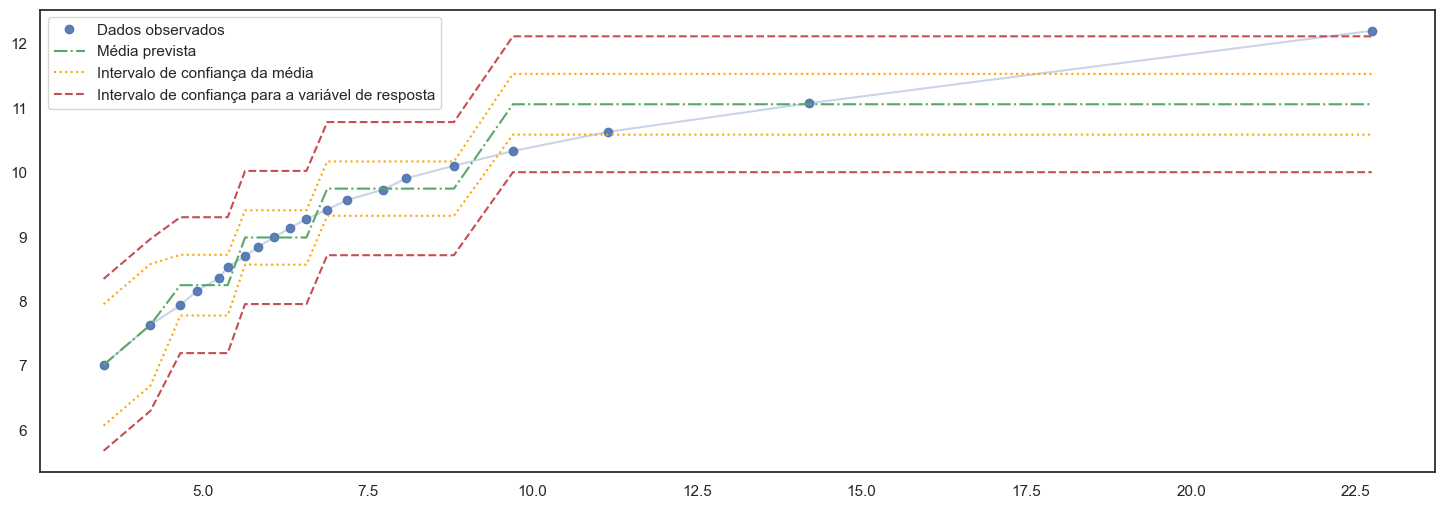

In [309]:
# Concatenando os resultados do modelo de regressão linear (modelo4) com os dados do DataFrame df_train3
df_modelo4 = pd.concat(objs=[df_train3, modelo4.get_prediction().summary_frame()], axis=1)

# Chamando a função para exibir o gráfico com os resultados do modelo de regressão linear (modelo4)
plotar_resultados_regressao(data=df_modelo4)

In [310]:
# Ajustando um novo modelo de regressão linear usando o logaritmo natural da variável 'tempo_emprego' como preditora da variável 'renda_log' no DataFrame df_train2
modelo5 = smf.ols(formula='renda_log ~ I(np.log(tempo_emprego))', data=df_train2).fit()

# Imprimindo o R-quadrado ajustado dos cinco modelos anteriores
print(f'R-quadrado ajustado (modelo1): {modelo1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo2): {modelo2.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo3): {modelo3.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo4): {modelo4.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo5): {modelo5.rsquared_adj:.2%}') 

# Exibindo um resumo completo do quinto modelo
modelo5.summary()

R-quadrado ajustado (modelo1): 41.74%
R-quadrado ajustado (modelo2): 41.74%
R-quadrado ajustado (modelo3): 81.15%
R-quadrado ajustado (modelo4): 87.31%
R-quadrado ajustado (modelo5): 97.51%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     745.1
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           4.24e-16
Time:                        20:56:53   Log-Likelihood:                 5.3671
No. Observations:                  20   AIC:                            -6.734
Df Residuals:                      18   BIC:                            -4.743
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.8201      0.205     18.665      0.000       3.390       4.250
I(np.log(tempo_emprego))     2.8085      0.103     27.297      0.000       2.592       3.025
==============================================================================
Omnibus:                        2.546   Durbin-Watson:                   0.214
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                1.975
Skew:                          -0.635   Prob(JB):                        0.372
Kurtosis:                       2.130   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [311]:
# Combinando os resultados do modelo de regressão linear (modelo5) com as duas primeiras colunas do DataFrame df_train2
df_modelo5 = pd.concat(objs=[df_train2.iloc[:,:2], modelo5.get_prediction().summary_frame().reset_index(drop=True)], axis=1)

# Exibindo o DataFrame df_modelo5
df_modelo5

,tempo_emprego,renda_log,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.495999,7.010163,7.335335,0.083480,7.159950,7.510720,6.889639,7.781031
1,4.207643,7.632577,7.855711,0.067958,7.712937,7.998485,7.421811,8.289612
2,4.660527,7.936228,8.142817,0.060270,8.016194,8.269440,7.713959,8.571674
3,4.918947,8.165258,8.294383,0.056580,8.175512,8.413254,7.867750,8.721015
4,5.252237,8.359802,8.478509,0.052541,8.368126,8.588893,8.054163,8.902856
5,5.379107,8.533222,8.545544,0.051211,8.437953,8.653135,8.121916,8.969173
6,5.643284,8.695236,8.680196,0.048806,8.577658,8.782735,8.257823,9.102570
7,5.842475,8.846803,8.777620,0.047311,8.678222,8.877018,8.355998,9.199242
8,6.083964,8.992746,8.891371,0.045857,8.795030,8.987713,8.470459,9.312283
9,6.324065,9.135799,9.000078,0.044786,8.905987,9.094169,8.579675,9.420481


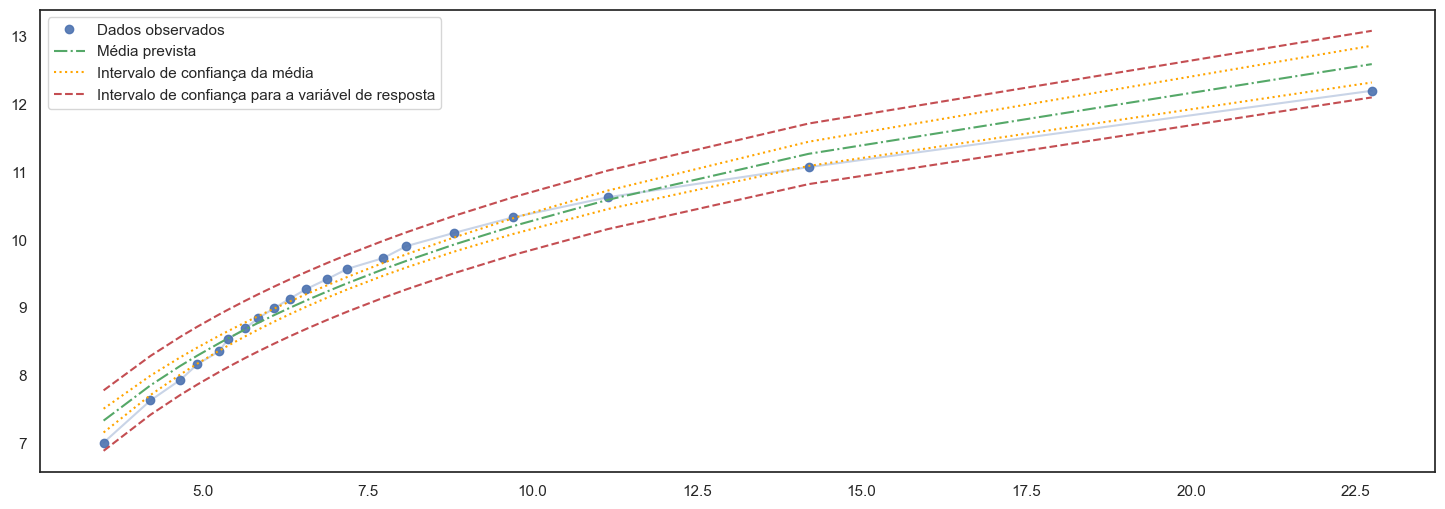

In [312]:
# Chamando a função para exibir o gráfico com os resultados do modelo de regressão linear (modelo5)
plotar_resultados_regressao(data=df_modelo5)

In [313]:
# Definindo um ponto de corte
C1 = 7.5

# Criando duas novas colunas no DataFrame df_train2, X_1 e X_2
# Preenchendo as colunas com valores da variável 'tempo_emprego' de acordo com a seguinte lógica:
# Se o valor da variável 'tempo_emprego' for menor ou igual a C1, o valor é mantido; caso contrário, o valor é substituído por C1
df_train2['X_1'] = (df_train2['tempo_emprego'] <= C1) * df_train2['tempo_emprego'] + (df_train2['tempo_emprego'] > C1) * C1
# X_2 contém os valores originais de 'tempo_emprego' se forem maiores que C1, caso contrário, os valores são substituídos por C1
df_train2['X_2'] = (df_train2['tempo_emprego'] > C1) * df_train2['tempo_emprego'] + (df_train2['tempo_emprego'] <= C1) * C1

# Exibindo o DataFrame df_train2
df_train2

,tempo_emprego,renda_log,tempo_emprego_cat,X_1,X_2
0,3.495999,7.010163,"(-inf, 3.885]",3.495999,7.500000
1,4.207643,7.632577,"(3.885, 4.523]",4.207643,7.500000
2,4.660527,7.936228,"(4.523, 5.548]",4.660527,7.500000
3,4.918947,8.165258,"(4.523, 5.548]",4.918947,7.500000
4,5.252237,8.359802,"(4.523, 5.548]",5.252237,7.500000
5,5.379107,8.533222,"(4.523, 5.548]",5.379107,7.500000
6,5.643284,8.695236,"(5.548, 6.825]",5.643284,7.500000
7,5.842475,8.846803,"(5.548, 6.825]",5.842475,7.500000
8,6.083964,8.992746,"(5.548, 6.825]",6.083964,7.500000
9,6.324065,9.135799,"(5.548, 6.825]",6.324065,7.500000


In [314]:
# Ajustando um novo modelo de regressão linear (modelo6) usando as variáveis 'X_1' e 'X_2' como preditoras da variável 'renda_log' no DataFrame df_train2
modelo6 = smf.ols(formula='renda_log ~ X_1 + X_2', data=df_train2).fit()

# Imprimindo o R-quadrado ajustado dos seis modelos anteriores
print(f'R-quadrado ajustado (modelo1): {modelo1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo2): {modelo2.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo3): {modelo3.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo4): {modelo4.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo5): {modelo5.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo6): {modelo6.rsquared_adj:.2%}') 

# Exibindo um resumo completo do sexto modelo
modelo6.summary()

R-quadrado ajustado (modelo1): 41.74%
R-quadrado ajustado (modelo2): 41.74%
R-quadrado ajustado (modelo3): 81.15%
R-quadrado ajustado (modelo4): 87.31%
R-quadrado ajustado (modelo5): 97.51%
R-quadrado ajustado (modelo6): 99.35%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1448.
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           1.03e-19
Time:                        20:56:59   Log-Likelihood:                 19.334
No. Observations:                  20   AIC:                            -32.67
Df Residuals:                      17   BIC:                            -29.68
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5666      0.115     30.981      0.000       3.324       3.809
X_1            0.6884      0.020     34.594      0.000       0.646       0.730
X_2            0.1568      0.007     22.592      0.000       0.142       0.171
==============================================================================
Omnibus:                        1.188   Durbin-Watson:                   0.759
Prob(Omnibus):                  0.552   Jarque-Bera (JB):                1.007
Skew:                          -0.496   Prob(JB):                        0.605
Kurtosis:                       2.526   Cond. No.                         59.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [315]:
# Combinando os resultados do modelo de regressão linear (modelo6) com as colunas do DataFrame df_train2
df_modelo6 = pd.concat(objs=[df_train2.iloc[:,[0,1,3,4]], modelo6.get_prediction().summary_frame()], axis=1)

# Exibindo o DataFrame df_modelo6
df_modelo6

,tempo_emprego,renda_log,X_1,X_2,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.495999,7.010163,3.495999,7.500000,7.148944,0.055876,7.031057,7.266832,6.907587,7.390302
1,4.207643,7.632577,4.207643,7.500000,7.638849,0.043549,7.546969,7.730729,7.409072,7.868627
2,4.660527,7.936228,4.660527,7.500000,7.950620,0.036406,7.873811,8.027430,7.726443,8.174798
3,4.918947,8.165258,4.918947,7.500000,8.128520,0.032745,8.059433,8.197607,7.906870,8.350170
4,5.252237,8.359802,5.252237,7.500000,8.357961,0.028704,8.297401,8.418522,8.138819,8.577103
5,5.379107,8.533222,5.379107,7.500000,8.445300,0.027432,8.387423,8.503177,8.226884,8.663716
6,5.643284,8.695236,5.643284,7.500000,8.627163,0.025392,8.573592,8.680734,8.409849,8.844478
7,5.842475,8.846803,5.842475,7.500000,8.764289,0.024495,8.712609,8.815969,8.547433,8.981145
8,6.083964,8.992746,6.083964,7.500000,8.930533,0.024247,8.879376,8.981690,8.713801,9.147265
9,6.324065,9.135799,6.324065,7.500000,9.095821,0.024934,9.043215,9.148427,8.878743,9.312900


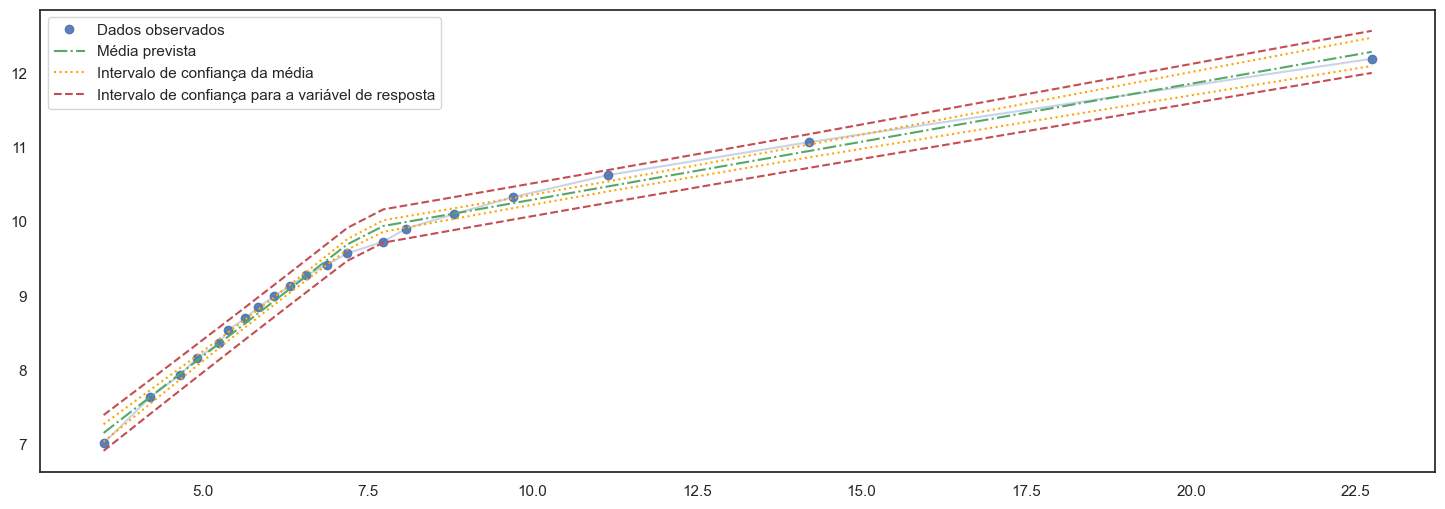

In [316]:
# Chamando a função para exibir o gráfico com os resultados do modelo de regressão linear (modelo6)
plotar_resultados_regressao(data=df_modelo6)

##### lowess

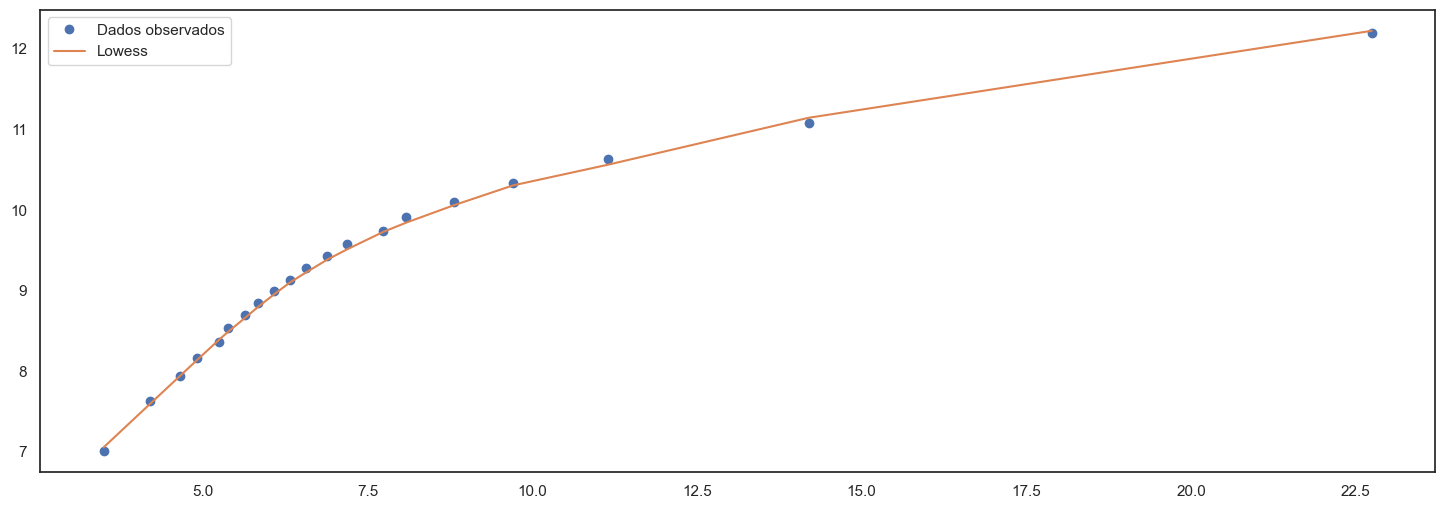

In [317]:
# Aplicando o método LOWESS (Local Regression) para ajustar uma linha suave aos dados de 'renda_log' em relação a 'tempo_emprego' no DataFrame df_train2
lowess = sm.nonparametric.lowess(endog=df_train2['renda_log'], exog=df_train2['tempo_emprego'], frac=2/3)

# Criando um gráfico para visualizar os dados observados e a linha suavizada LOWESS
plt.figure(figsize=(18,6))

# Plotando os dados observados
plt.plot(df_train2['tempo_emprego'], df_train2['renda_log'], 'o', label='Dados observados')

# Plotando a linha suavizada LOWESS
plt.plot(df_train2['tempo_emprego'], lowess[:,1], label='Lowess')

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [318]:
# Usando a função interp1d para interpolar os valores suavizados gerados pelo método LOWESS
f = interp1d(x=lowess[:,0], y=lowess[:,1], bounds_error=False)

# Adicionando os valores interpolados como uma nova coluna chamada 'lowess' no DataFrame df_train2
df_train2['lowess'] = f(df_train2['tempo_emprego'])

# Exibindo o DataFrame df_train2 com a nova coluna 'lowess'
df_train2

,tempo_emprego,renda_log,tempo_emprego_cat,X_1,X_2,lowess
0,3.495999,7.010163,"(-inf, 3.885]",3.495999,7.500000,7.052899
1,4.207643,7.632577,"(3.885, 4.523]",4.207643,7.500000,7.597723
2,4.660527,7.936228,"(4.523, 5.548]",4.660527,7.500000,7.943294
3,4.918947,8.165258,"(4.523, 5.548]",4.918947,7.500000,8.140488
4,5.252237,8.359802,"(4.523, 5.548]",5.252237,7.500000,8.391928
5,5.379107,8.533222,"(4.523, 5.548]",5.379107,7.500000,8.482876
6,5.643284,8.695236,"(5.548, 6.825]",5.643284,7.500000,8.660540
7,5.842475,8.846803,"(5.548, 6.825]",5.842475,7.500000,8.797566
8,6.083964,8.992746,"(5.548, 6.825]",6.083964,7.500000,8.952516
9,6.324065,9.135799,"(5.548, 6.825]",6.324065,7.500000,9.099393


In [319]:
# Ajustando um novo modelo de regressão linear (modelo7) usando a variável 'lowess' como preditora da variável 'renda_log' no DataFrame df_train2
modelo7 = smf.ols(formula='renda_log ~ lowess', data=df_train2).fit()

# Imprimindo o R-quadrado ajustado dos sete modelos anteriores
print(f'R-quadrado ajustado (modelo1): {modelo1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo2): {modelo2.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo3): {modelo3.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo4): {modelo4.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo5): {modelo5.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo6): {modelo6.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo7): {modelo7.rsquared_adj:.2%}') 

# Exibindo um resumo completo do sétimo modelo
modelo7.summary()

R-quadrado ajustado (modelo1): 41.74%
R-quadrado ajustado (modelo2): 41.74%
R-quadrado ajustado (modelo3): 81.15%
R-quadrado ajustado (modelo4): 87.31%
R-quadrado ajustado (modelo5): 97.51%
R-quadrado ajustado (modelo6): 99.35%
R-quadrado ajustado (modelo7): 99.90%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.848e+04
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           1.45e-28
Time:                        20:57:11   Log-Likelihood:                 37.247
No. Observations:                  20   AIC:                            -70.49
Df Residuals:                      18   BIC:                            -68.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0323      0.069      0.471      0.643      -0.112       0.176
lowess         0.9990      0.007    135.938      0.000       0.984       1.014
==============================================================================
Omnibus:                        4.145   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                3.050
Skew:                          -0.954   Prob(JB):                        0.218
Kurtosis:                       2.874   Cond. No.                         73.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [320]:
# Combinando os resultados do modelo de regressão linear (modelo7) com as colunas do DataFrame df_train2
df_modelo7 = pd.concat(objs=[df_train2.iloc[:,[0,1,5]], modelo7.get_prediction().summary_frame()], axis=1)

# Exibindo o DataFrame df_modelo7
df_modelo7

,tempo_emprego,renda_log,lowess,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.495999,7.010163,7.052899,7.078426,0.018449,7.039666,7.117186,6.986620,7.170232
1,4.207643,7.632577,7.597723,7.622724,0.015060,7.591084,7.654364,7.533690,7.711759
2,4.660527,7.936228,7.943294,7.967961,0.013091,7.940457,7.995465,7.880311,8.055611
3,4.918947,8.165258,8.140488,8.164965,0.012064,8.139619,8.190311,8.077968,8.251962
4,5.252237,8.359802,8.391928,8.416162,0.010895,8.393274,8.439051,8.329849,8.502475
5,5.379107,8.533222,8.482876,8.507023,0.010519,8.484922,8.529123,8.420915,8.593130
6,5.643284,8.695236,8.660540,8.684515,0.009876,8.663765,8.705265,8.598744,8.770286
7,5.842475,8.846803,8.797566,8.821409,0.009474,8.801505,8.841314,8.735839,8.906979
8,6.083964,8.992746,8.952516,8.976210,0.009132,8.957023,8.995396,8.890804,9.061616
9,6.324065,9.135799,9.099393,9.122945,0.008931,9.104181,9.141708,9.037633,9.208257


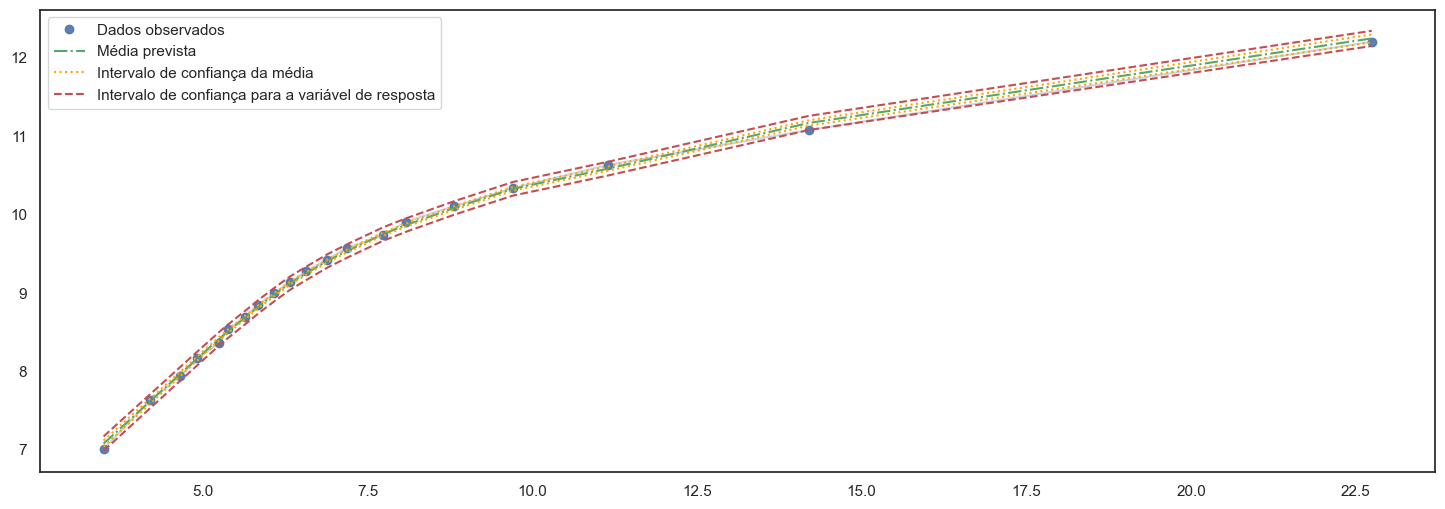

In [321]:
# Chamando a função para exibir o gráfico com os resultados do modelo de regressão linear (modelo7)
plotar_resultados_regressao(data=df_modelo7)

### Avaliando o modelo
###### Avalie os resultados dos modelos construidos na base de testes.

In [325]:
df.reset_index(inplace=True)

In [326]:
df_train['data_ref'] = df['data_ref']

In [327]:
df_ = df_train[['data_ref', 'tempo_emprego_fillna_2', 'renda_log']]

In [328]:
df_ = (df_.groupby(by=['data_ref', pd.cut(x=df_train.renda, bins=retbins)])  # Agrupando por data_ref e intervalos de renda
       .mean()  # Calculando a média de todas as colunas numéricas por padrão
       [['tempo_emprego_fillna_2', 'renda_log']]  # Selecionando apenas as colunas desejadas
       .reset_index(level='renda', drop=True)  # Removendo o índice 'renda'
       .rename(columns={'tempo_emprego_fillna_2': 'tempo_emprego'})  # Renomeando a coluna tempo_emprego_fillna_2
)


df_

,tempo_emprego,renda_log
data_ref,,
2015-01-01,3.950856,6.945560
2015-01-01,5.075084,7.624840
2015-01-01,5.784068,7.930471
2015-01-01,6.113118,8.163630
2015-01-01,6.700322,8.359317
...,...,...
2015-12-01,13.327626,10.096354
2015-12-01,16.105922,10.331155
2015-12-01,18.885714,10.623817


In [329]:
df['data_ref'] = pd.to_datetime(df['data_ref'], format='%Y-%m-%d')
df.set_index('data_ref', inplace=True)

In [330]:
# Dividindo o DataFrame df_ em conjuntos de treinamento e teste com base em datas
df_train_ = df_[df_.index <= df_.index.unique().max() - pd.DateOffset(months=3)].copy()  # Conjunto de treinamento contendo dados até três meses antes da data mais recente
df_test_ = df_[~df_.index.isin(df_train_.index)].copy()  # Conjunto de teste contendo os dados restantes

# Imprimindo informações sobre o tamanho e as datas dos conjuntos de treinamento e teste
print(f'''
Base de treino: {df_train_.shape} - {df_train_.index.unique().strftime('%b%y').values}
Base de teste: {df_test_.shape} - {df_test_.index.unique().strftime('%b%y').values}
''')


Base de treino: (180, 2) - ['Jan15' 'Feb15' 'Mar15' 'Apr15' 'May15' 'Jun15' 'Jul15' 'Aug15' 'Sep15']
Base de teste: (60, 2) - ['Oct15' 'Nov15' 'Dec15']



CATEGORIZAÇÃO
R-quadrado ajustado do modelo: 69.72%
R-quadrado com dados de teste: 73.60%



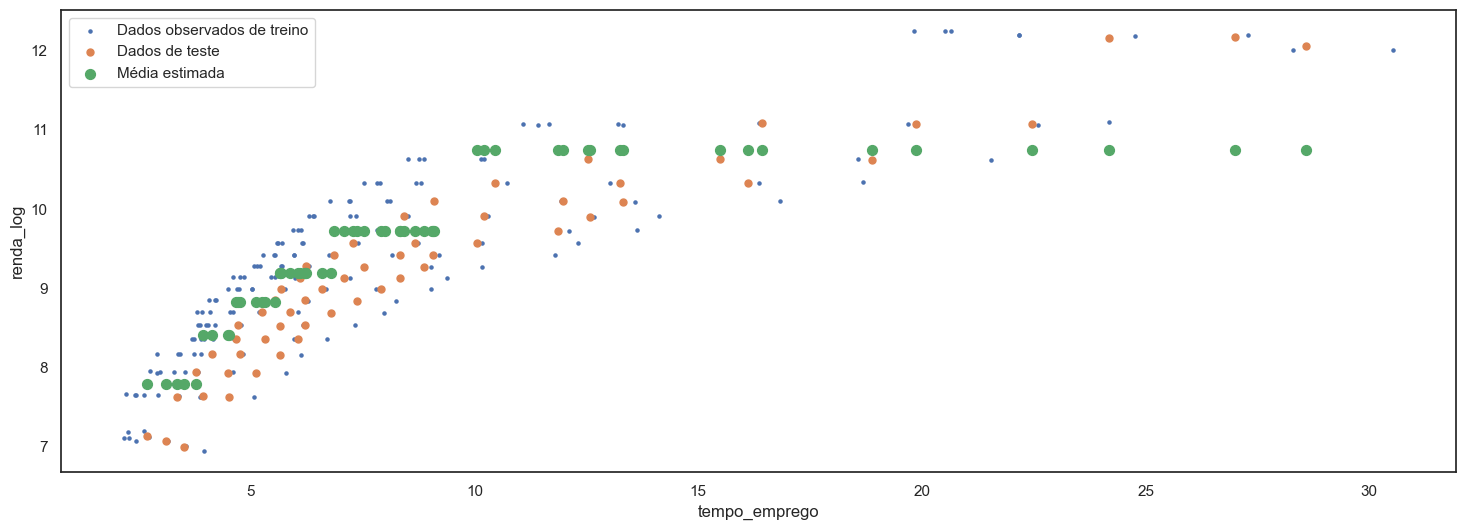

In [331]:
# Categorizando a variável 'tempo_emprego' nos conjuntos de treinamento e teste usando os mesmos bins (q) definidos anteriormente
df_train_['tempo_emprego_cat'] = pd.cut(x=df_train_.tempo_emprego, bins=q)
df_test_['tempo_emprego_cat'] = pd.cut(x=df_test_.tempo_emprego, bins=q)

# Ajustando um modelo de regressão linear (cat_model) usando a variável 'tempo_emprego_cat' como preditora da variável 'renda_log' nos dados de treinamento
cat_model = smf.ols(formula='renda_log ~ tempo_emprego_cat', data=df_train_).fit()

# Imprimindo o R-quadrado ajustado do modelo e o R-quadrado estimado nos dados de teste
print(f'''CATEGORIZAÇÃO
R-quadrado ajustado do modelo: {cat_model.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2_score(y_true=df_test_.renda_log, y_pred=cat_model.predict(df_test_)):.2%}
''')

# Criando uma função para plotar os resultados de um modelo de regressão com a base de testes
def plotar_resultados_teste(modelo: sm.regression.linear_model.RegressionResultsWrapper) -> None:
    """
    Plota os dados observados de treinamento, os dados de teste e a média estimada pelo modelo.

    Parâmetros:
        modelo (sm.regression.linear_model.RegressionResultsWrapper): Modelo de regressão.

    Retorna:
        None
    """
    # Criação do gráfico para exibir os dados observados de treinamento, os dados de teste e a média estimada pelo modelo
    plt.figure(figsize=(18,6))
    plt.scatter(df_train_.tempo_emprego, df_train_.renda_log, s=5, label='Dados observados de treino')
    plt.scatter(df_test_.tempo_emprego, df_test_.renda_log, s=25, label='Dados de teste')
    plt.scatter(df_test_.tempo_emprego, modelo.predict(df_test_), s=50, label='Média estimada')
    plt.xlabel(xlabel='tempo_emprego')
    plt.ylabel(ylabel='renda_log')
    plt.legend(loc=2)
    plt.show()
    
# Chamando a função para exibir o gráfico com os resultados do modelo de regressão linear (cat_model) na base de teste
plotar_resultados_teste(modelo=cat_model)

TRANSFORMAÇÃO SOBRE X
R-quadrado ajustado do modelo: 79.38%
R-quadrado com dados de teste: 84.47%



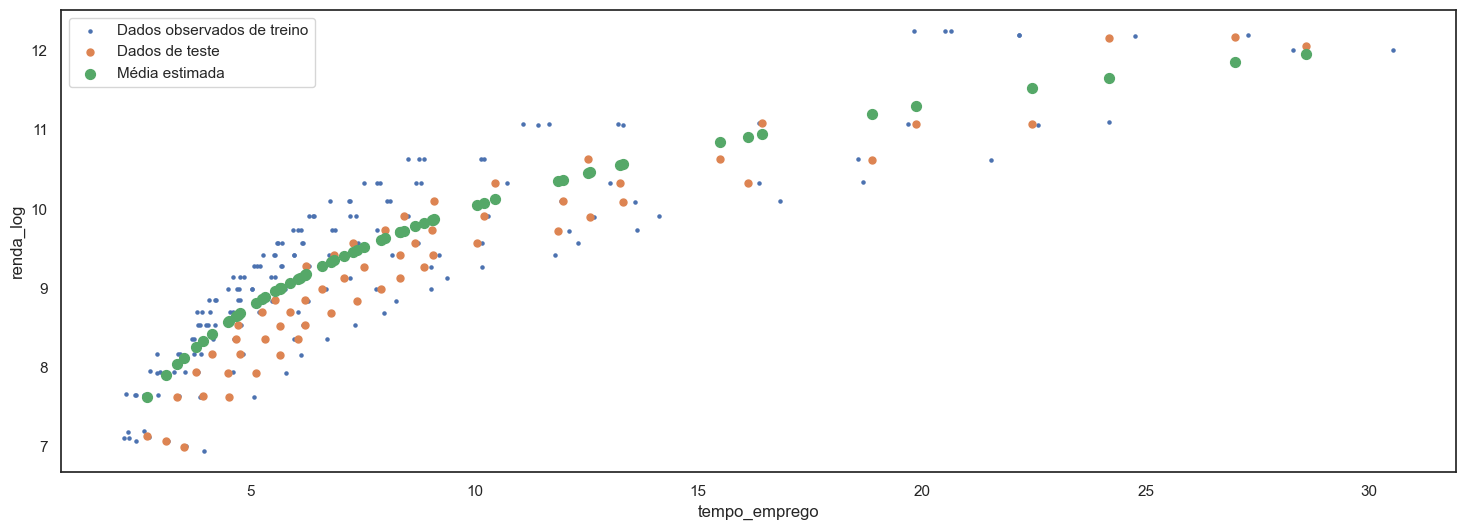

In [332]:
# Ajustando um modelo de regressão linear (transform_model) usando a variável 'tempo_emprego' transformada por meio de uma função logarítmica como preditora da variável 'renda_log' nos dados de treinamento
transform_model = smf.ols(formula='renda_log ~ I(np.log(tempo_emprego))', data=df_train_).fit()

# Calculando o R-quadrado ajustado do modelo e o R-quadrado estimado nos dados de teste
r2 = r2_score(y_true=df_test_.renda_log, y_pred=transform_model.predict(df_test_))
print(f'''TRANSFORMAÇÃO SOBRE X
R-quadrado ajustado do modelo: {transform_model.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2:.2%}
''')

# Chamando a função para exibir o gráfico com os resultados do modelo de regressão linear (transform_model) na base de teste
plotar_resultados_teste(modelo=transform_model)

REGRESSÃO SEGMENTADA
R-quadrado ajustado do modelo: 79.13%
R-quadrado com dados de teste: 84.90%



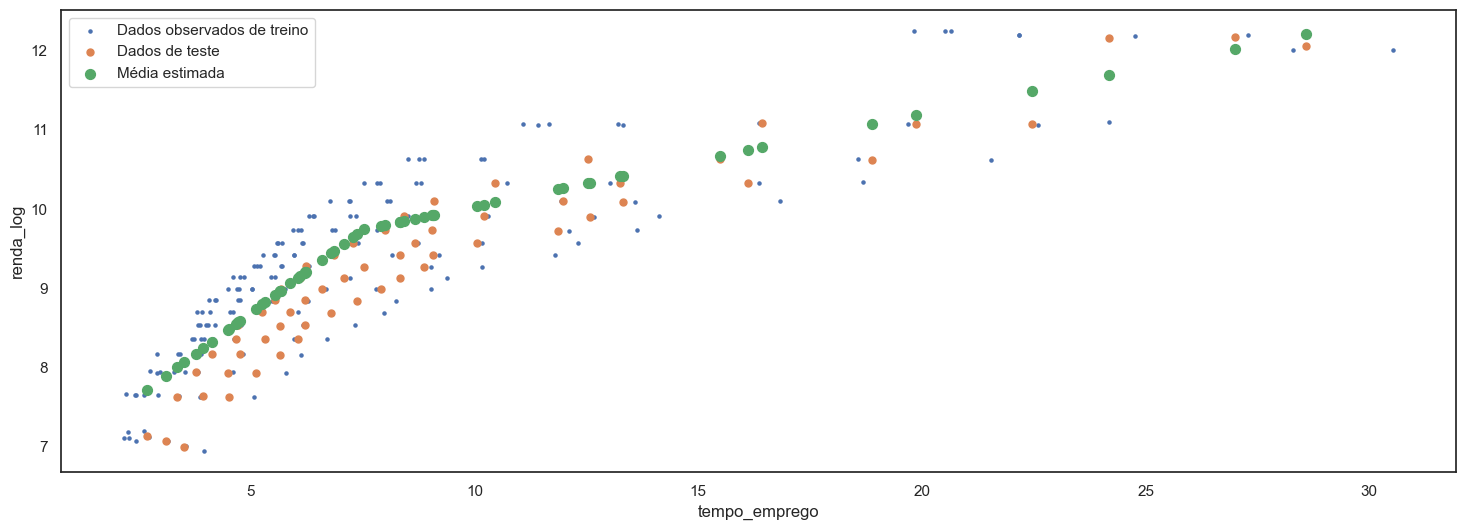

In [333]:
# Definindo o ponto de corte para segmentar a variável 'tempo_emprego'
C1 = 7.5

# Segmentando a variável 'tempo_emprego' nos conjuntos de treinamento e teste e criando variáveis indicadoras 'X_1' e 'X_2'
df_train_['X_1'] = (df_train_['tempo_emprego'] <= C1) * df_train_['tempo_emprego'] + (df_train_['tempo_emprego'] >  C1) * C1
df_train_['X_2'] = (df_train_['tempo_emprego'] >  C1) * df_train_['tempo_emprego'] + (df_train_['tempo_emprego'] <= C1) * C1

df_test_['X_1'] = (df_test_['tempo_emprego'] <= C1) * df_test_['tempo_emprego'] + (df_test_['tempo_emprego'] >  C1) * C1
df_test_['X_2'] = (df_test_['tempo_emprego'] >  C1) * df_test_['tempo_emprego'] + (df_test_['tempo_emprego'] <= C1) * C1

# Ajustando um modelo de regressão linear (segmented_model) usando as variáveis indicadoras 'X_1' e 'X_2' como preditoras da variável 'renda_log' nos dados de treinamento
segmented_model = smf.ols(formula='renda_log ~ X_1 + X_2', data=df_train_).fit()

# Calculando o R-quadrado ajustado do modelo e o R-quadrado estimado nos dados de teste
print(f'''REGRESSÃO SEGMENTADA
R-quadrado ajustado do modelo: {segmented_model.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2_score(y_true=df_test_.renda_log, y_pred=segmented_model.predict(df_test_)):.2%}
''')

# Chamando a função para exibir o gráfico com os resultados do modelo de regressão linear (segmented_model) na base de teste
plotar_resultados_teste(modelo=segmented_model)

LOWESS
R-quadrado ajustado do modelo: 79.82%
R-quadrado com dados de teste: 84.79%



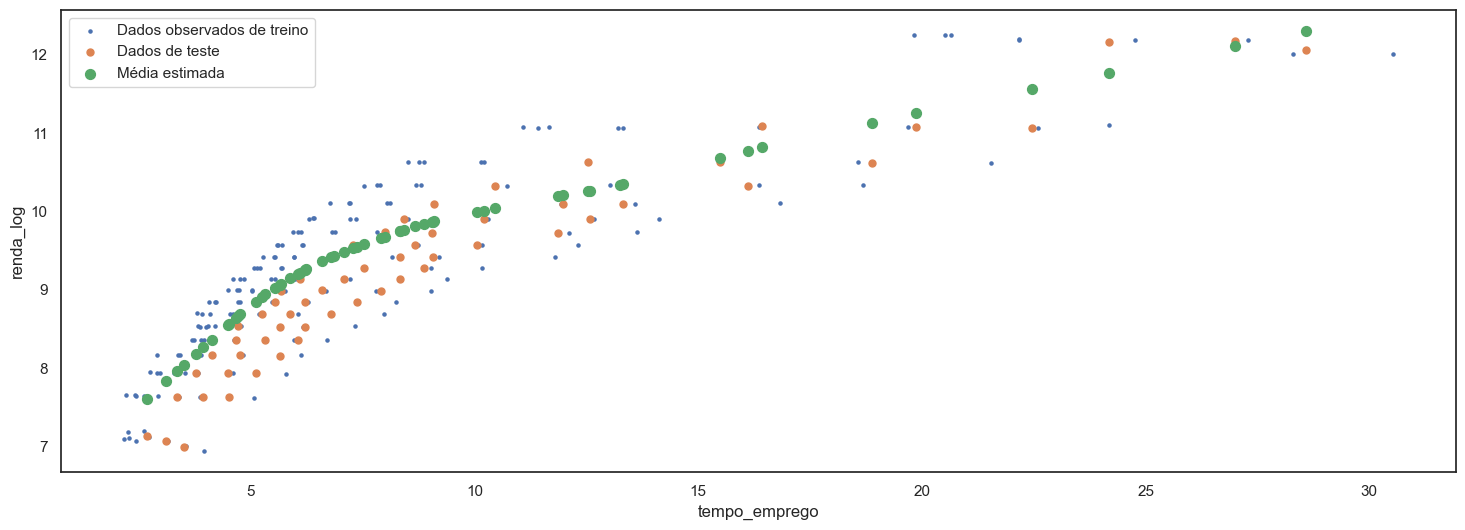

In [334]:
# Calculando LOWESS para os dados de treinamento
lowess_ = sm.nonparametric.lowess(endog=df_train_.renda_log, exog=df_train_.tempo_emprego, frac=2/3)

# Interpolando os valores suavizados para estimar 'renda_log' com base em 'tempo_emprego'
f_ = interp1d(x=lowess_[:,0], y=lowess_[:,1], bounds_error=False)

# Criando uma nova coluna 'lowess' nos conjuntos de treinamento e teste
df_train_['lowess'] = f_(df_train_.tempo_emprego)
df_test_['lowess'] = f_(df_test_.tempo_emprego)

# Ajustando um modelo de regressão linear (lowess_model) usando 'lowess' como preditora de 'renda_log' nos dados de treinamento
lowess_model = smf.ols(formula='renda_log ~ lowess', data=df_train_).fit()

# Calculando o R-quadrado ajustado do modelo e o R-quadrado estimado nos dados de teste
print(f'''LOWESS
R-quadrado ajustado do modelo: {lowess_model.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2_score(y_true=df_test_.renda_log, y_pred=lowess_model.predict(df_test_)):.2%}
''')

# Chamando a função para exibir o gráfico com os resultados do modelo de regressão linear (lowess_model) na base de teste
plotar_resultados_teste(modelo=lowess_model)